In [10]:
import numpy as np
import pandas as pd
import tarfile
import skimage.exposure
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import itertools
import time


from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder

import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Dense, BatchNormalization
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

In [11]:
## Creation of the set of images

folder_path = r'D:\Mines Paris-PSL\S4E\Machine learning\Exercises\Exercise_3\photo'

images = []
labels = []

# Iterate over all files and subfolders in the folder
for root, dirs, files in os.walk(folder_path):
    for file in files:
        # Check if the file is an image (you can adjust the condition based on your image file extensions)
        if file.endswith(('.jpg', '.png', '.jpeg')):
            # Access the image file path
            image_path = os.path.join(root, file)

            image = plt.imread(image_path)

            images.append(image)
            labels.append(os.path.basename(root))

images = np.array(images)
labels = np.array(labels)

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

WITHOUT DATA AUGMENTATION

In [13]:
## Lenet implementation

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_LeNet_model(input_shape, num_classes):
    model = Sequential()

    # Layer 1: Convolutional layer with 6 filters, 5x5 kernel, and ReLU activation
    model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 2: Convolutional layer with 16 filters, 5x5 kernel, and ReLU activation
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the feature maps
    model.add(Flatten())

    # Layer 3: Fully connected layer with 120 units and ReLU activation
    model.add(Dense(120, activation='relu'))

    # Layer 4: Fully connected layer with 84 units and ReLU activation
    model.add(Dense(84, activation='relu'))

    # Layer 5: Output layer with 'num_classes' units and softmax activation
    model.add(Dense(num_classes, activation='softmax'))

    return model


In [14]:
from sklearn.model_selection import StratifiedKFold

# Define the number of folds for cross-validation and other hyperparameters
n_folds = 5  # Number of folds for cross-validation
learning_rate = 0.001
batch_size = 32
epochs = 100

# Encode the labels
label_encoder = LabelEncoder()
labels_deep = label_encoder.fit_transform(labels)

# Initialize lists to store the evaluation metrics for each fold
val_accuracy_per_fold = []

# Perform cross-validation using StratifiedKFold
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

for fold, (train_index, val_index) in enumerate(skf.split(images, labels_deep)):
    print(f"Fold {fold + 1}")
    X_train_fold = images[train_index]
    y_train_fold = labels_deep[train_index]
    X_val_fold = images[val_index]
    y_val_fold = labels_deep[val_index]

    # Encode the labels
    #label_encoder = LabelEncoder()
    #y_train_fold = label_encoder.fit_transform(y_train_fold)
    #y_val_fold = label_encoder.fit_transform(y_val_fold)

    # Define the input shape and number of classes
    input_shape = X_train.shape[1:]
    num_classes = len(np.unique(labels))

    # Create the LeNet model
    model = create_LeNet_model(input_shape, num_classes)

    # Compile the model
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

    start = time.time()

    history = model.fit(X_train_fold, y_train_fold, batch_size=batch_size, epochs=epochs, validation_data=(X_val_fold, y_val_fold))

    fit_time = time.time() - start

    # Evaluate the model on validation data
    y_val_pred = model.predict(X_val_fold)
    y_val_pred_labels = np.argmax(y_val_pred, axis=1)
    y_val_true_labels = y_val_fold
    #np.argmax(np.reshape(y_val_fold, (-1, 1)), axis=1)
    val_accuracy = accuracy_score(y_val_true_labels, y_val_pred_labels)

    val_accuracy_per_fold.append(val_accuracy)

# Calculate and display the mean and standard deviation of the evaluation metrics across folds
print("Cross-validation results:")
print(f"Mean validation accuracy: {np.mean(val_accuracy_per_fold):.4f} (+/- {np.std(val_accuracy_per_fold):.4f})")
print("fit time", fit_time)

Fold 1
Epoch 1/100
38/38 [==============================] - 6s 138ms/step - loss: 3.0587 - accuracy: 0.2315 - val_loss: 2.1358 - val_accuracy: 0.2748
Epoch 2/100
38/38 [==============================] - 4s 101ms/step - loss: 1.9067 - accuracy: 0.3427 - val_loss: 2.0722 - val_accuracy: 0.2881
Epoch 3/100
38/38 [==============================] - 4s 112ms/step - loss: 1.5973 - accuracy: 0.4539 - val_loss: 2.0706 - val_accuracy: 0.3013
Epoch 4/100
38/38 [==============================] - 4s 106ms/step - loss: 1.2135 - accuracy: 0.5826 - val_loss: 1.9900 - val_accuracy: 0.3444
Epoch 5/100
38/38 [==============================] - 4s 105ms/step - loss: 0.7993 - accuracy: 0.7386 - val_loss: 2.2951 - val_accuracy: 0.3709
Epoch 6/100
38/38 [==============================] - 4s 108ms/step - loss: 0.5202 - accuracy: 0.8390 - val_loss: 2.2137 - val_accuracy: 0.4106
Epoch 7/100
38/38 [==============================] - 4s 106ms/step - loss: 0.2822 - accuracy: 0.9137 - val_loss: 2.5716 - val_accuracy:

WITH DATA AUGMENTATION

In [15]:
## Data augmentation 

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [16]:
##LeNet with data augmentation

from sklearn.model_selection import StratifiedKFold

# Define the number of folds for cross-validation and other hyperparameters
n_folds = 5  # Number of folds for cross-validation
learning_rate = 0.001
batch_size = 32
epochs = 100

# Encode the labels
label_encoder = LabelEncoder()
labels_deep = label_encoder.fit_transform(labels)

# Initialize lists to store the evaluation metrics for each fold
val_accuracy_per_fold_augm = []

# Perform cross-validation using StratifiedKFold
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

for fold, (train_index, val_index) in enumerate(skf.split(images, labels_deep)):
    print(f"Fold {fold + 1}")
    X_train_fold = images[train_index]
    y_train_fold = labels_deep[train_index]
    X_val_fold = images[val_index]
    y_val_fold = labels_deep[val_index]

    # Encode the labels
    #label_encoder = LabelEncoder()
    #y_train_fold = label_encoder.fit_transform(y_train_fold)
    #y_val_fold = label_encoder.fit_transform(y_val_fold)

    # Define the input shape and number of classes
    input_shape = X_train_fold.shape[1:]
    num_classes = len(np.unique(labels))

    # Create the LeNet model
    model = create_LeNet_model(input_shape, num_classes)

    # Compile the model
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

    history = model.fit(datagen.flow(X_train_fold, y_train_fold, batch_size=batch_size), epochs=epochs, validation_data=(X_val_fold, y_val_fold))

    # Evaluate the model on validation data
    y_val_pred_augm = model.predict(X_val_fold)
    y_val_pred_labels_augm = np.argmax(y_val_pred_augm, axis=1)
    y_val_true_labels_augm = y_val_fold
    #np.argmax(np.reshape(y_val_fold, (-1, 1)), axis=1)
    val_accuracy_augm = accuracy_score(y_val_true_labels_augm, y_val_pred_labels_augm)

    val_accuracy_per_fold_augm.append(val_accuracy_augm)

# Calculate and display the mean and standard deviation of the evaluation metrics across folds
print("Cross-validation results:")
print(f"Mean validation accuracy: {np.mean(val_accuracy_per_fold_augm):.4f} (+/- {np.std(val_accuracy_per_fold_augm):.4f})")

Fold 1
Epoch 1/100
38/38 [==============================] - 12s 281ms/step - loss: 5.2275 - accuracy: 0.1519 - val_loss: 2.3385 - val_accuracy: 0.1987
Epoch 2/100
38/38 [==============================] - 8s 211ms/step - loss: 2.1386 - accuracy: 0.2390 - val_loss: 2.1865 - val_accuracy: 0.2219
Epoch 3/100
38/38 [==============================] - 10s 262ms/step - loss: 2.0814 - accuracy: 0.2249 - val_loss: 2.1553 - val_accuracy: 0.2219
Epoch 4/100
38/38 [==============================] - 12s 305ms/step - loss: 2.0554 - accuracy: 0.2465 - val_loss: 2.1202 - val_accuracy: 0.2517
Epoch 5/100
38/38 [==============================] - 13s 348ms/step - loss: 2.0443 - accuracy: 0.2373 - val_loss: 2.1053 - val_accuracy: 0.2649
Epoch 6/100
38/38 [==============================] - 12s 301ms/step - loss: 2.0154 - accuracy: 0.2531 - val_loss: 2.0643 - val_accuracy: 0.2616
Epoch 7/100
38/38 [==============================] - 11s 297ms/step - loss: 2.0061 - accuracy: 0.2589 - val_loss: 2.0478 - val_acc

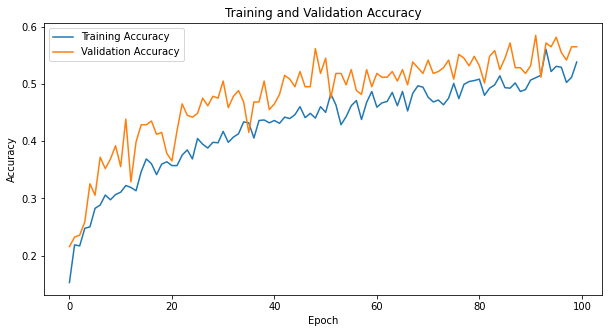

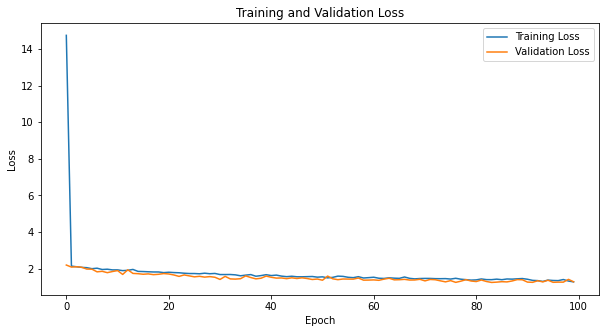

In [19]:
import matplotlib.pyplot as plt

# Initialize lists to store the training and validation accuracy and loss
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

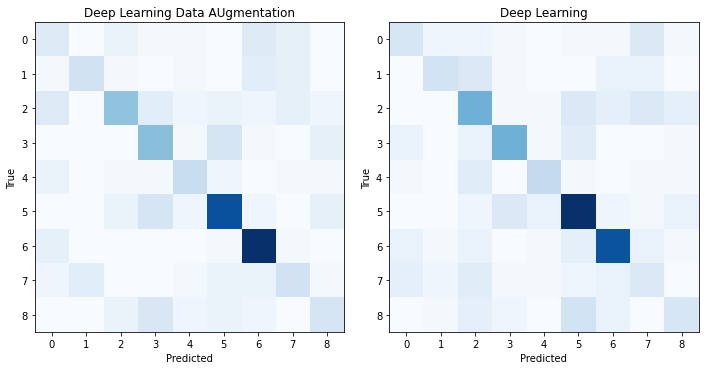

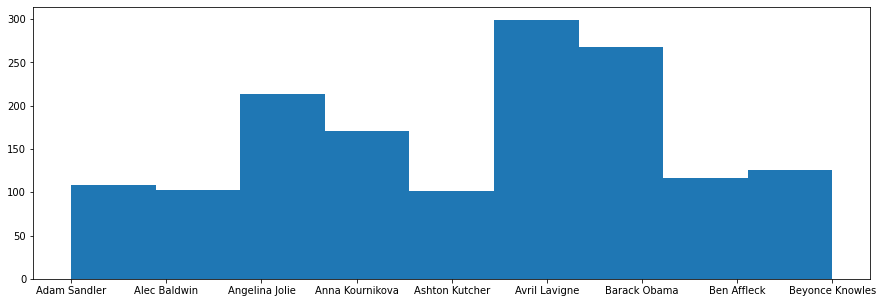

dict_keys(['Adam Sandler', 'Alec Baldwin', 'Angelina Jolie', 'Anna Kournikova', 'Ashton Kutcher', 'Avril Lavigne', 'Barack Obama', 'Ben Affleck', 'Beyonce Knowles'])


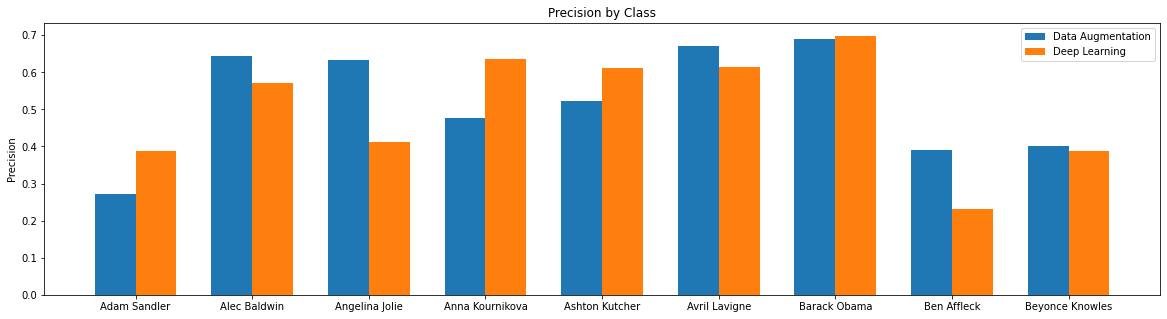

There is no significant difference between the two approaches.


In [18]:
#Compare the results with and without the data augmentation

## Detailed comparison : LeNet with and without data augmentation

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from scipy.stats import ttest_rel
from collections import Counter

# Assume you have obtained the predictions and true labels for each approach
data_augm_prediction = y_val_pred_labels_augm
deep_learning_predictions = y_val_pred_labels
true_labels_deep_learning = y_val_true_labels
true_labels_data_augm = y_val_true_labels_augm

# Compute the confusion matrices
traditional_cm = confusion_matrix(y_val_true_labels_augm, y_val_pred_labels_augm)
deep_learning_cm = confusion_matrix(y_val_true_labels, y_val_pred_labels)

# Plot the confusion matrices
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].imshow(traditional_cm, cmap='Blues')
axes[0].set_title('Deep Learning Data AUgmentation')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[1].imshow(deep_learning_cm, cmap='Blues')
axes[1].set_title('Deep Learning')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
plt.tight_layout()
plt.show()

#Plot Class
plt.figure(figsize=(15,5))
plt.hist(labels, bins = 9)
plt.show()

# Calculate precision, recall, and F1-score for each class
traditional_metrics = precision_recall_fscore_support(true_labels_data_augm, data_augm_prediction, average=None)
deep_learning_metrics = precision_recall_fscore_support(true_labels_deep_learning, deep_learning_predictions, average=None)

# Plot class-specific metrics
classes = Counter(labels)
print(classes.keys())
x = np.arange(len(classes.keys()))
width = 0.35
fig, ax = plt.subplots(figsize=(20,5))
ax.bar(x - width/2, traditional_metrics[0], width, label='Data Augmentation')
ax.bar(x + width/2, deep_learning_metrics[0], width, label='Deep Learning')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Precision')
ax.set_title('Precision by Class')
ax.legend()
plt.show()

# Perform statistical test
_, p_value = ttest_rel(traditional_metrics[0], deep_learning_metrics[0])
if p_value < 0.05:
    print("There is a significant difference between the two approaches.")
else:
    print("There is no significant difference between the two approaches.")


In [7]:
## Squeezenet structure

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, GlobalAveragePooling2D, Activation

def fire_module(x, squeeze, expand):
    squeezed = Conv2D(squeeze, (1, 1), activation='relu')(x)
    expand1x1 = Conv2D(expand, (1, 1), activation='relu')(squeezed)
    expand3x3 = Conv2D(expand, (3, 3), padding='same', activation='relu')(squeezed)
    return concatenate([expand1x1, expand3x3])

def SqueezeNet(input_shape, num_classes):
    input_tensor = Input(shape=input_shape)

    x = Conv2D(96, (7, 7), strides=(2, 2), activation='relu', padding='same')(input_tensor)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 16, 64)
    x = fire_module(x, 16, 64)
    x = fire_module(x, 32, 128)

    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 32, 128)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 64, 256)

    x = Conv2D(num_classes, (1, 1), activation='relu', padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax')(x)

    model = Model(inputs=input_tensor, outputs=output)
    return model

# Example usage:
input_shape = X_train.shape[1:]  # Input image shape
num_classes = 1000  # Number of output classes
model = SqueezeNet(input_shape, num_classes)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 50, 50, 96)   14208       ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 24, 24, 96)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 24, 24, 16)   1552        ['max_pooling2d[0][0]']      

In [8]:
## Squeezenet

from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.optimizers import RMSprop

# Define the number of folds for cross-validation and other hyperparameters
n_folds = 5  # Number of folds for cross-validation
learning_rate = 0.001
batch_size = 32
epochs = 100

# Encode the labels
label_encoder = LabelEncoder()
labels_deep = label_encoder.fit_transform(labels)

# Initialize lists to store the evaluation metrics for each fold
val_accuracy_per_fold = []

# Perform cross-validation using StratifiedKFold
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

for fold, (train_index, val_index) in enumerate(skf.split(images, labels_deep)):
    print(f"Fold {fold + 1}")
    X_train_fold = images[train_index]
    y_train_fold = labels_deep[train_index]
    X_val_fold = images[val_index]
    y_val_fold = labels_deep[val_index]

    # Encode the labels
    #label_encoder = LabelEncoder()
    #y_train_fold = label_encoder.fit_transform(y_train_fold)
    #y_val_fold = label_encoder.fit_transform(y_val_fold)

    # Define the input shape and number of classes
    input_shape = X_train.shape[1:]
    num_classes = len(np.unique(labels))

    # Create the LeNet model
    model = SqueezeNet(input_shape, num_classes)

    optimizer = RMSprop()

    # Compile the model
    model.compile(optimizer=optimizer, loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

    start = time.time()

    history = model.fit(X_train_fold, y_train_fold, batch_size=batch_size, epochs=epochs, validation_data=(X_val_fold, y_val_fold))

    fit_time = time.time() - start

    # Evaluate the model on validation data
    y_val_pred = model.predict(X_val_fold)
    y_val_pred_labels = np.argmax(y_val_pred, axis=1)
    y_val_true_labels = y_val_fold
    #np.argmax(np.reshape(y_val_fold, (-1, 1)), axis=1)
    val_accuracy = accuracy_score(y_val_true_labels, y_val_pred_labels)

    val_accuracy_per_fold.append(val_accuracy)

# Calculate and display the mean and standard deviation of the evaluation metrics across folds
print("Cross-validation results:")
print(f"Mean validation accuracy: {np.mean(val_accuracy_per_fold):.4f} (+/- {np.std(val_accuracy_per_fold):.4f})")
print("fit time", fit_time)

Fold 1
Epoch 1/100
38/38 [==============================] - 24s 499ms/step - loss: 2.4433 - accuracy: 0.1876 - val_loss: 2.1685 - val_accuracy: 0.1954
Epoch 2/100
38/38 [==============================] - 24s 633ms/step - loss: 2.1550 - accuracy: 0.1726 - val_loss: 2.1387 - val_accuracy: 0.1755
Epoch 3/100
38/38 [==============================] - 20s 535ms/step - loss: 2.1398 - accuracy: 0.1900 - val_loss: 2.1425 - val_accuracy: 0.1987
Epoch 4/100
38/38 [==============================] - 20s 537ms/step - loss: 2.1395 - accuracy: 0.1942 - val_loss: 2.1384 - val_accuracy: 0.1987
Epoch 5/100
38/38 [==============================] - 20s 529ms/step - loss: 2.1383 - accuracy: 0.2025 - val_loss: 2.1402 - val_accuracy: 0.1755
Epoch 6/100
38/38 [==============================] - 20s 526ms/step - loss: 2.1387 - accuracy: 0.2025 - val_loss: 2.1379 - val_accuracy: 0.1987
Epoch 7/100
38/38 [==============================] - 20s 527ms/step - loss: 2.1386 - accuracy: 0.1917 - val_loss: 2.1439 - val_ac

In [9]:
## Lenet implementation

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_LeNet_model(input_shape, num_classes):
    model = Sequential()

    # Layer 1: Convolutional layer with 6 filters, 5x5 kernel, and ReLU activation
    model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 2: Convolutional layer with 16 filters, 5x5 kernel, and ReLU activation
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the feature maps
    model.add(Flatten())

    # Layer 3: Fully connected layer with 120 units and ReLU activation
    model.add(Dense(120, activation='relu'))

    # Layer 4: Fully connected layer with 84 units and ReLU activation
    model.add(Dense(84, activation='relu'))

    # Layer 5: Output layer with 'num_classes' units and softmax activation
    model.add(Dense(num_classes, activation='softmax'))

    return model